# Week 9. Convolutional Neural Networks: an Introduction

## Setup

In [1]:
# Python ≥ 3.8 is required
import sys
assert sys.version_info >= (3, 8)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
## Import tensorflow
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version', tf.__version__)
print('Keras version', keras.__version__)

Tensorflow version 2.11.0
Keras version 2.11.0


## 1. A quick overview on Convolutions

To explain how convolutions works we will load a couple of sample images:
* the image of a china temple
* the image of a flower

In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [4]:
height

427

In [5]:
width

640

In [6]:
channels

3

In [7]:
batch_size

2

Now we can print out our images and see how they look like:

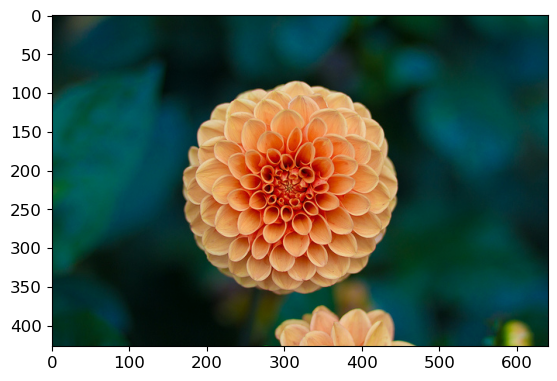

In [8]:
_ = plt.imshow(flower)

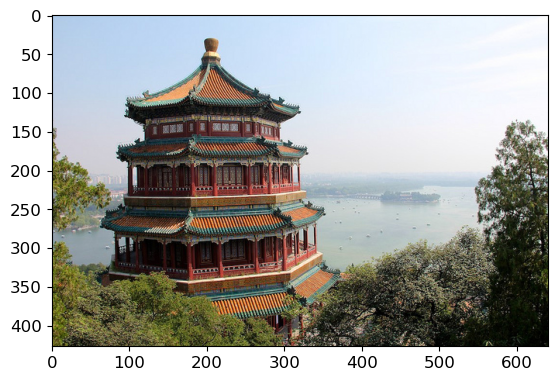

In [9]:
_ = plt.imshow(china)

We will now create three 2D convolutional filters.

Each filter will be $7 \times 7$ in size and applied to all the channels in the image (our images are RGB, so we have three channels).

The filters are:
* a vertical bar filter
* a horizontal bar filter
* a filter consisting of a single positive central pixel surrounded by negative pixels. This, as we will see, behaves as an edge detector.

In [10]:
# Create 3 7x7xn_channels filters, the first one as a vertical line 
# the second one as a horizontal one

# first we create a create a 4D array 
# 7 X 7 X number of channels X number of filters 
filters = np.zeros(shape=(7, 7, channels, 3), dtype=np.float32)

# our first filters is a vertical line 
filters[:, 3, :, 0] = 1  # vertical line

# our second filter is a horizontal line 
filters[3, :, :, 1] = 1  # horizontal line

# our third filter is -1 everywhere except in the centre
# where it is = 48 so that the sum of all the pixels is zero.
# This will behaves as an "edge filter"
edge_filter = -1.0*np.ones((7, 7))
edge_filter[3, 3] = 48
edge_filter = np.repeat(edge_filter[:, :, np.newaxis], 3, axis=2)
edge_filter = tf.constant(edge_filter, shape=(7, 7, channels), dtype=tf.float32)

filters[:, :, :, 2] = edge_filter  # edge filter


Now we can print out our three convolutional filters and see how they look like:

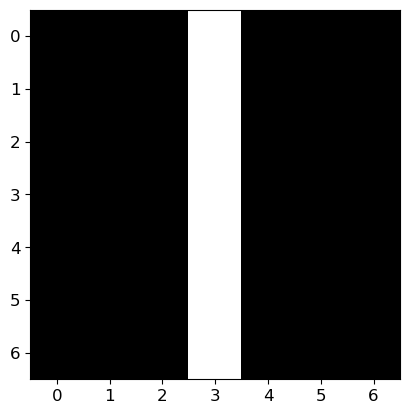

In [11]:
_ = plt.imshow(filters[:, :, 0, 0], cmap='gray')

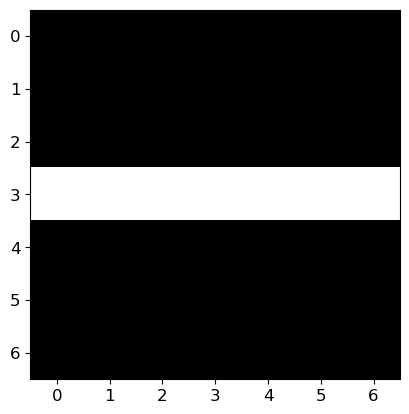

In [12]:
_ = plt.imshow(filters[:, :, 0, 1], cmap='gray')

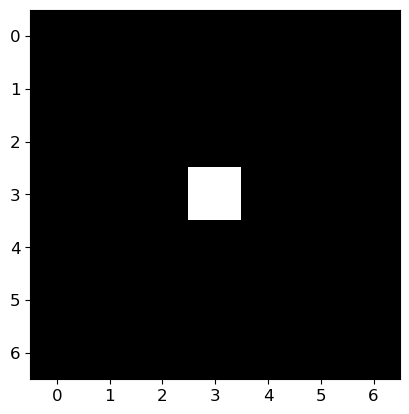

In [13]:
_ = plt.imshow(filters[:, :, 0, 2], cmap='gray')

In [14]:
filters[:, :, 0, 2]

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., 48., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]], dtype=float32)

Now, let's perform the 2D convolution:

In [15]:
outputs = tf.nn.conv2d(
    images,
    filters,
    strides=1,
    padding="SAME"
)

In [16]:
# A couple of functions to plot greyscale and colour images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# crop images
def crop(images):
    return images[150:220, 130:250]

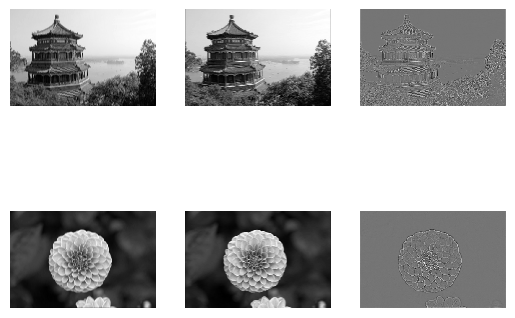

In [17]:
for image_index in (0, 1):
    for feature_map_index in (0, 1, 2):
        plt.subplot(2, 3, image_index * 3 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

### Filter 1: Vertical line detection

See this detail of the Chinese temple picture

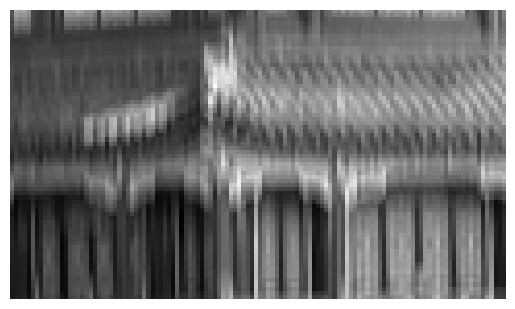

In [18]:
plot_image(crop(outputs[0, :, :, 0]))

### Filter 2: Horizontal line detection

See this detail of the Chinese temple picture

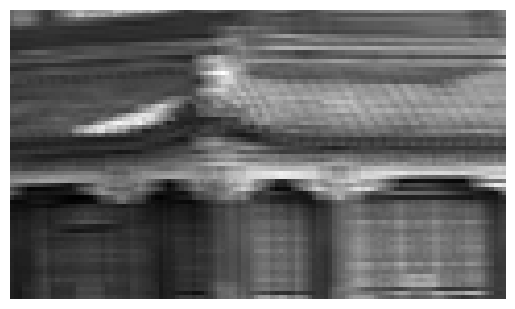

In [19]:
plot_image(crop(outputs[0, :, :, 1]))

### Filter 3:Edge detection

This is very analogous to the behaviour of some cells in the Primary Visual Area of the Primates Brain (area V1).

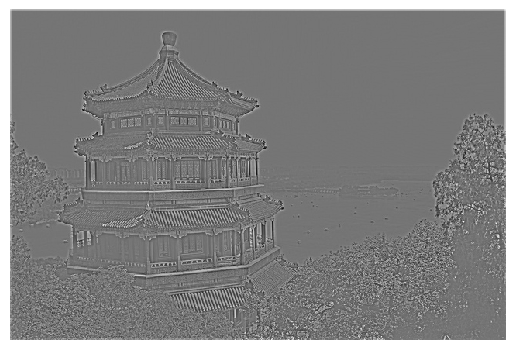

In [20]:
plot_image(outputs[0, :, :, 2])

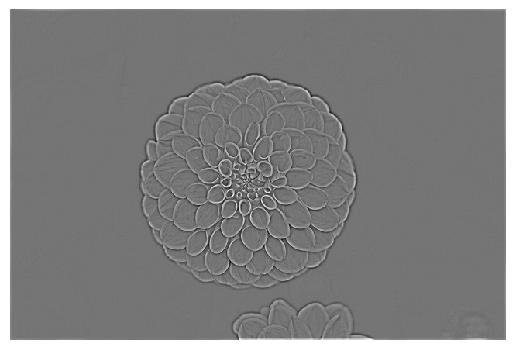

In [21]:
plot_image(outputs[1, :, :, 2])

## 2. Convolutional and pooling layers in Keras

### 2.1 Convolutional Layer

In convolutional layers, the filters are not pre-defined/hard-coded but they are learned during training

In [22]:
conv = keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding="SAME",
    activation="relu"
)
conv

### 2.2 Pooling Layer

In [23]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
max_pool

## 3. A Convolutional Network for the Fashion MNIST dataset (image classification)

In [24]:
### Load the data; create training, test and validation sets
(
    X_train_full, y_train_full
), (
    X_test, y_test
) = keras.datasets.fashion_mnist.load_data()
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# apply standard scaling to our data
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# add one inner dimension to the dataset so that it becomes 4-dimensional
# 2D Convolutional networks take 4D tensors as inputs with shape (n_samples, width, height, n_channels)
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [25]:
X_train.shape

(55000, 28, 28, 1)

**Exercise 01:** Let us implement a simple CNN to tackle the Fashion MNIST dataset. We will implement a CNN with these requirements:
  1. a first 2-D Convolutional layer with 64 7x7 kernel filters, ReLU activation, and zero padding. Remember that the imput shape must be of the size of a single frame of the input image ($width \times height \times n_{channels}$) 
  2. a max-pooling layer with pool size of 2
  3. a second 2-D Convolutional layer with 128 3x3 kernel, ReLU activation, and zero padding.
  4. a third 2-D Convolutional layer with 128 3x3 kernel, ReLU activation, and zero padding.
  5. a max-pooling layer with pool size of 2
  6. Now we repeat the same structure again: two more 2-D Convolutional layers with 256 3x3 kernel, ReLU activation, and zero padding, followed by one more MaxPooling layer with pool size of 2
  7. After that, stack a fully connected network, composed of two hidden dense layers and a dense output layer. you must flatten the inputs to the first dense layer, since a dense network expects a 1D array of features for each instance. Furthermore, add two dropout layers to the Dense hidden layers, with a dropout rate of 50% each, to reduce overfitting. The first dense layer will have 128 neurons, the second hidden layer will have 64.

The number of kernel filters grows as we go up in the CNN towards the output layer: it is initially 64, then 128, then 256. It makes sense to have it increasing: the number of low-level visual feature is generally fairly low (e.g., edges, small circles...), but there are various ways to use them to generate higher-level features. Doubling the number of filters after each pooling layer is a common practice. A pooling layer divides each spatial dimension by a factor of 2, so we can afford to double the number of feature maps in the next layer without parameter explosion and increase of memory usage.

In [51]:
# write your solution here

n_net = keras.models.Sequential(
    [
        #1. first 2-D Convolutional layer with 64 7x7 kernel filters, ReLU activation, and zero padding.
        keras.layers.Conv2D(
            filters=64,
            kernel_size=7,
            strides=1,
            padding="SAME",
            activation="relu"
        ),
        #2. a max-pooling layer with pool size of 2
        keras.layers.MaxPool2D(pool_size=2),
        
        #3. a second 2-D Convolutional layer with 128 3x3 kernel, ReLU activation, and zero padding.
        keras.layers.Conv2D(
            filters=128,
            kernel_size=3,
            strides=1,
            padding="SAME",
            activation="relu"
        ),
        #4. a third 2-D Convolutional layer with 128 3x3 kernel, ReLU activation, and zero padding.
        keras.layers.Conv2D(
            filters=128,
            kernel_size=3,
            strides=1,
            padding="SAME",
            activation="relu"
        ),
        #5. a max-pooling layer with pool size of 2
        keras.layers.MaxPool2D(pool_size=2),
        
        #6. Now we repeat the same structure again: 
        #     two more 2-D Convolutional layers with 256 3x3 kernel, ReLU activation, and zero padding, 
        keras.layers.Conv2D(
            filters=128,
            kernel_size=3,
            strides=1,
            padding="SAME",
            activation="relu"
        ),
        keras.layers.Conv2D(
            filters=128,
            kernel_size=3,
            strides=1,
            padding="SAME",
            activation="relu"
        ),
        # followed by one more MaxPooling layer with pool size of 2
        keras.layers.MaxPool2D(pool_size=2),
        
        # 7. 
        # After that, stack a fully connected network, composed of two hidden dense layers and a dense output layer. 
        
        # you must flatten the inputs to the first dense layer, since a dense network expects a 1D array of features for each instance. 
        keras.layers.Flatten(input_shape=[28, 28]),
        
        # Furthermore, add two dropout layers to the Dense hidden layers, with a dropout rate of 50% each, to reduce overfitting. 
        keras.layers.Dropout(rate=0.5),
        # The first dense layer will have 128 neurons,
        keras.layers.Dense(
            128, activation="relu", kernel_initializer="he_normal"
        ),
        #the second hidden layer will have 64.
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(
            64, activation="relu", kernel_initializer="he_normal"
        ),
        
        # Dense output layer - the ten categories ?
         keras.layers.Dense(10, activation="softmax")
    ]
)

In [37]:
n_net.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Nadam(),
    metrics=[keras.metrics.sparse_categorical_accuracy]
)

In [38]:
history = n_net.fit(
    X_train,
    y_train,
    epochs=10,  # 50 recommended, but 10 chosen just for time...
    validation_data=(X_valid, y_valid)
)

Epoch 1/10
1719/1719 [==============================] - 33s 18ms/step - loss: 27.6163 - sparse_categorical_accuracy: 0.0920 - val_loss: 27.5423 - val_sparse_categorical_accuracy: 0.0934
Epoch 2/10
1719/1719 [==============================] - 31s 18ms/step - loss: 27.6163 - sparse_categorical_accuracy: 0.0936 - val_loss: 27.5423 - val_sparse_categorical_accuracy: 0.0966
Epoch 3/10
1719/1719 [==============================] - 31s 18ms/step - loss: 27.6163 - sparse_categorical_accuracy: 0.0930 - val_loss: 27.5423 - val_sparse_categorical_accuracy: 0.0996
Epoch 4/10
1719/1719 [==============================] - 30s 18ms/step - loss: 27.6163 - sparse_categorical_accuracy: 0.0927 - val_loss: 27.5422 - val_sparse_categorical_accuracy: 0.0998
Epoch 5/10
1719/1719 [==============================] - 30s 18ms/step - loss: 27.6163 - sparse_categorical_accuracy: 0.0901 - val_loss: 27.5422 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/10
1719/1719 [==============================] - 31s 18ms/step 

In [39]:
# print out the summary of your model
n_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)        

In [ ]:
# save the network
net_A.save("my_net_B.h5")

In [50]:
keras.backend.clear_session()

**Exercise 02:** Now let's compile and train the model. Use the correct loss function, the NADAM optimizer, and "accuracy" as a metric. Train the network ideally for at least 10 epochs.
If the model takes too much to compile you can consider increasing the stride, or reducing the number of filters. This will likely affect your accuracy. On my 2019 MacBookPro each epoch takes about 6 minutes to complete, so expect a full training session of 10 epochs to last 1 hour or more. Once you have successfully trained your model you can save it for later usage/deployment

ND (23/03/23): training on an 2021 MacBook Pro with M1 Pro chip - 

In [52]:
# compile your model here:

n_net.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Nadam(),
    metrics=[keras.metrics.sparse_categorical_accuracy]
)


In [53]:
# train your model here and return the history object:

history = n_net.fit(
    X_train,
    y_train,
    epochs=10,  # 10 recommended
    validation_data=(X_valid, y_valid)
)


Epoch 1/10


NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall' defined at (most recent call last):
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-53-83a7f2a35a45>", line 3, in <module>
      history = n_net.fit(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall'
could not find registered platform with id: 0x13e0ef3b0
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_train_function_83417]

Finally we can evaluate the performance on the test set, if we are happy with the training result.

In [1]:
# this cell should work as it is if the previous ones have been coded correctly
score = n_net.evaluate(X_test, y_test)

NameError: name 'n_net' is not defined

In [ ]:
X_new = X_test[:10] # pretend we have new images
y_pred = n_net.predict(X_new)

In [ ]:
y_pred

**Exercise 03:** How can print out the predicted classes? Do it here:


In [ ]:
# write your solution here

# extending the above example - 

predicted_classes = y_pred.argmax(axis=1)
print(predicted_classes)

model = load_model('my_net_A.h5')

'my_net_A.h5' is a file that has been created in the directory by the above training

In [55]:

# ChatGPT's attempt!

# full - from loading the fashion_mnist set


from keras.datasets import fashion_mnist
from keras.models import load_model
from keras.utils import to_categorical

# Load the Fashion MNIST dataset
(_, _), (test_images, test_labels) = fashion_mnist.load_data()

# Preprocess the data
test_images = test_images.astype('float32') / 255.0
test_labels = to_categorical(test_labels)

# Load the trained model
model = load_model('my_net_A.h5')

# Make predictions on the test data
predictions = model.predict(test_images)

# Get the predicted classes
predicted_classes = predictions.argmax(axis=1)

# Print the predicted classes
print(predicted_classes)

313/313 [==============================] - 2s 6ms/step
[7 4 6 ... 4 6 7]
